In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.display import display
plt.rc('font', family='Verdana')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.set_option('display.max_columns', 60)

data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep = ';')
data.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,0,1,220,18.0,0,0,1,1,1,6,2,1,1580,1580,NaN
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,0,1,137,97.0,1,0,1,1,1,6,1,1,4020,4020,NaN
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,0,1,251,84.0,0,0,1,2,1,11,0,0,0,0,NaN
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,0,36,168.0,1,1,1,1,1,6,3,1,"1589,923333",1590,NaN
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,0,1,83,101.0,1,0,1,2,1,16,2,1,"1152,15",2230,NaN


In [3]:
def small_categories_aggregation(column, n_samples, value='Укрупненная категория', dataset=data):
    '''
    Укрупняет категории и числовые столбцы в датасете
    :param column: имя стоблца в датасете data
    :param n_samples: порог наблюдений, ниже которого категории объединяются в одну
    :param value: значение, которым будет заполнено
    :param dataset: датасет для изменения
    :return:
    '''

    tmp_small_columns = dataset[column].value_counts()[dataset[column].value_counts() < n_samples].index

    for col in tmp_small_columns:
        dataset.at[dataset[column] == col, column] = value

In [4]:
# указано в условии
data['PREVIOUS_CARD_NUM_UTILIZED'] = data['PREVIOUS_CARD_NUM_UTILIZED'].replace(data['PREVIOUS_CARD_NUM_UTILIZED'][0], 0)

data.drop('AGREEMENT_RK', axis=1, inplace=True)

In [5]:
pd.read_excel('data/Credit_OTP_columns_description.xls')

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,TARGET,целевая переменная:отклик на маркетинговую кам...
2,AGE,возраст клиента
3,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...
4,SOCSTATUS_PENS_FL,социальный статус клиента относительно пенсии ...
5,GENDER,"пол клиента (1 - мужчина, 0 - женщина)"
6,CHILD_TOTAL,количество детей клиента
7,DEPENDANTS,количество иждивенцев клиента
8,EDUCATION,образование
9,MARITAL_STATUS,семейное положение


In [6]:
data.describe()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,TERM,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,PREVIOUS_CARD_NUM_UTILIZED
count,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.0,15223.000000,1.522300e+04,1.385500e+04,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000
mean,0.119030,40.406096,0.909610,0.134468,0.654536,1.099389,0.645208,0.838534,0.951192,0.886356,0.838074,0.905341,0.309794,0.116337,0.073967,0.215661,0.009788,0.019247,0.043684,8.101031,0.0,0.588649,3.039340e+03,2.922120e+02,0.611640,0.054786,0.910136,1.387769,0.751889,7.875977,0.195362,0.130198,0.019050
std,0.323835,11.601068,0.286748,0.341165,0.475535,0.995411,0.812252,0.367973,0.215473,0.317389,0.368395,0.292754,0.462424,0.320844,0.261726,0.411293,0.098451,0.137397,0.204398,4.094090,0.0,0.492095,2.624554e+05,2.436483e+04,0.487393,0.227569,0.285996,0.793566,0.988499,7.955747,0.685022,0.355702,0.137663
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.0,0.000000,-2.600000e+01,1.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.0,0.000000,4.100000e+01,2.400000e+01,0.000000,0.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000
50%,0.000000,39.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.0,1.000000,1.080000e+02,4.800000e+01,1.000000,0.000000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000
75%,0.000000,50.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.0,1.000000,2.040000e+02,1.100000e+02,1.000000,0.000000,1.000000,2.000000,1.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,67.000000,1.000000,1.000000,1.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,0.0,1.000000,2.810200e+07,2.867959e+06,1.000000,1.000000,1.000000,11.000000,11.000000,114.000000,13.000000,8.000000,2.000000


# Missing

In [7]:
for i in data.columns:
    print(i)
    print(data[i].unique())
    print()

TARGET
[0 1]

AGE
[49 32 52 39 30 29 35 41 53 43 54 26 62 45 38 65 34 28 37 42 33 27 31 40 63
 61 44 59 48 24 23 47 58 51 56 22 36 57 50 46 55 66 25 60 64 21 67]

SOCSTATUS_WORK_FL
[1 0]

SOCSTATUS_PENS_FL
[0 1]

GENDER
[1 0]

CHILD_TOTAL
[ 2  3  4  1  0  5  6  7  8 10]

DEPENDANTS
[1 3 0 2 4 5 6 7]

EDUCATION
['Среднее специальное' 'Среднее' 'Неполное среднее' 'Высшее'
 'Неоконченное высшее' 'Два и более высших образования' 'Ученая степень']

MARITAL_STATUS
['Состою в браке' 'Гражданский брак' 'Разведен(а)' 'Не состоял в браке'
 'Вдовец/Вдова']

GEN_INDUSTRY
['Торговля' 'Информационные технологии' 'Образование'
 'Государственная служба' 'Другие сферы' 'Сельское хозяйство'
 'Здравоохранение' 'Металлургия/Промышленность/Машиностроение' nan
 'Коммунальное хоз-во/Дорожные службы' 'Строительство' 'Транспорт'
 'Банк/Финансы' 'Ресторанный бизнес/Общественное питание' 'Страхование'
 'Нефтегазовая промышленность' 'СМИ/Реклама/PR-агенства' 'Энергетика'
 'Салоны красоты и здоровья' 'ЧОП/Детектив

In [8]:
# одно уникальное значение
data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

In [9]:
miss_columns = data.count(axis=0)[data.count(axis=0) < len(data)].index

for i in miss_columns:
    print(data.isnull()[i].value_counts())
    print()
    
miss_columns

False    13856
True      1367
Name: GEN_INDUSTRY, dtype: int64

False    13856
True      1367
Name: GEN_TITLE, dtype: int64

False    13856
True      1367
Name: ORG_TP_STATE, dtype: int64

False    13858
True      1365
Name: ORG_TP_FCAPITAL, dtype: int64

False    13856
True      1367
Name: JOB_DIR, dtype: int64

False    14928
True       295
Name: TP_PROVINCE, dtype: int64

False    15222
True         1
Name: REGION_NM, dtype: int64

False    13855
True      1368
Name: WORK_TIME, dtype: int64



Index(['GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL',
       'JOB_DIR', 'TP_PROVINCE', 'REGION_NM', 'WORK_TIME'],
      dtype='object')

In [10]:
for i in miss_columns:
    print(i)
    print(data[i].value_counts())
    print()

GEN_INDUSTRY
Торговля                                     2385
Другие сферы                                 1709
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108
Салоны красоты и здоровья            

In [11]:
data['GEN_INDUSTRY'].fillna('Пропуски', inplace=True)
data['GEN_INDUSTRY'].value_counts()

Торговля                                     2385
Другие сферы                                 1709
Пропуски                                     1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [12]:
data['GEN_TITLE'].fillna('Пропуски', inplace=True)
data['GEN_TITLE'].value_counts()

Специалист                        7010
Рабочий                           3075
Пропуски                          1367
Служащий                           904
Руководитель среднего звена        697
Работник сферы услуг               563
Высококвалифиц. специалист         549
Руководитель высшего звена         427
Индивидуальный предприниматель     217
Другое                             177
Руководитель низшего звена         136
Военнослужащий по контракту         88
Партнер                             13
Name: GEN_TITLE, dtype: int64

In [13]:
data['ORG_TP_STATE'].fillna('Пропуски', inplace=True)
data['ORG_TP_STATE'].value_counts()

Частная компания                  6523
Государственная комп./учреж.      6112
Пропуски                          1367
Индивидуальный предприниматель     957
Некоммерческая организация         243
Частная ком. с инос. капиталом      21
Name: ORG_TP_STATE, dtype: int64

In [14]:
data['ORG_TP_FCAPITAL'].value_counts()

Без участия    13688
С участием       170
Name: ORG_TP_FCAPITAL, dtype: int64

In [15]:
data['ORG_TP_FCAPITAL'].fillna('Пропуски', inplace=True)
data['ORG_TP_FCAPITAL'].value_counts()

Без участия    13688
Пропуски        1365
С участием       170
Name: ORG_TP_FCAPITAL, dtype: int64

In [16]:
data['JOB_DIR'].fillna('Пропуски', inplace=True)
data['JOB_DIR'].value_counts()

Участие в основ. деятельности    11452
Пропуски                          1367
Вспомогательный техперсонал       1025
Бухгалтерия, финансы, планир.      481
Адм-хоз. и трансп. службы          279
Снабжение и сбыт                   217
Служба безопасности                164
Кадровая служба и секретариат      101
Пр-техн. обесп. и телеком.          75
Юридическая служба                  53
Реклама и маркетинг                  9
Name: JOB_DIR, dtype: int64

In [17]:
data['TP_PROVINCE'].fillna('Пропуски', inplace=True)
data['TP_PROVINCE'].value_counts()[:20]

Краснодарский край       790
Кемеровская область      668
Алтайский край           436
Приморский край          413
Читинская область        412
Ставропольский край      411
Ростовская область       405
Челябинская область      354
Свердловская область     340
Волгоградская область    339
Кировская область        333
Саратовская область      317
Воронежская область      312
Красноярский край        295
Пропуски                 295
Вологодская область      292
Омская область           286
Татарстан                272
Хабаровский край         258
Санкт-Петербург          254
Name: TP_PROVINCE, dtype: int64

In [18]:
len(data) - sum(data['REGION_NM'].value_counts())

1

In [19]:
data['REGION_NM'].fillna(data['REGION_NM'].value_counts().index[0], inplace=True)

In [20]:
data['WORK_TIME'].value_counts()

36.0      1263
24.0      1140
60.0       989
12.0       861
48.0       800
120.0      544
72.0       518
6.0        448
18.0       423
84.0       419
96.0       378
180.0      319
108.0      274
240.0      218
144.0      211
8.0        188
30.0       187
132.0      165
156.0      155
204.0      153
7.0        144
168.0      139
192.0      135
3.0        134
4.0        119
360.0      114
300.0      108
10.0       107
216.0      107
14.0        98
          ... 
860.0        1
600.0        1
463.0        1
129.0        1
136.0        1
99.0         1
239.0        1
179.0        1
303.0        1
407.0        1
187.0        1
445.0        1
166.0        1
107.0        1
242.0        1
236.0        1
244.0        1
457.0        1
195.0        1
185.0        1
1254.0       1
395.0        1
4320.0       1
169.0        1
229.0        1
576.0        1
176.0        1
207.0        1
362.0        1
391.0        1
Name: WORK_TIME, Length: 302, dtype: int64

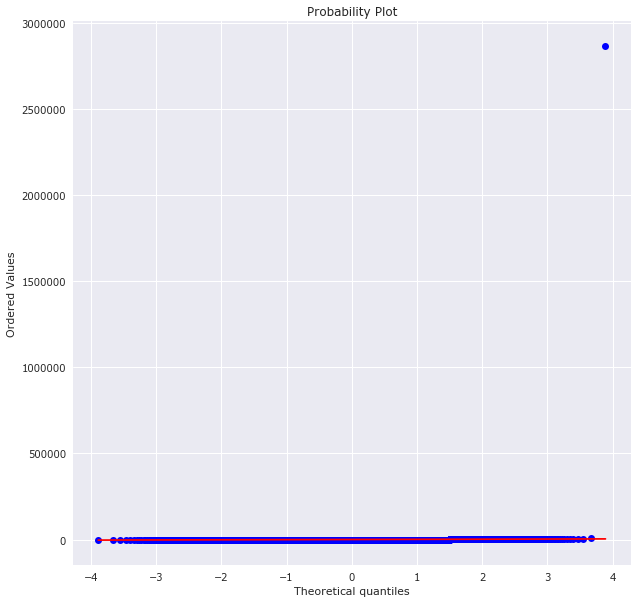

In [21]:
## QQ Plot
plt.subplots(figsize=(10, 10))

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(data['WORK_TIME'].dropna().sort_values(), dist="norm", plot=plt)
plt.show()

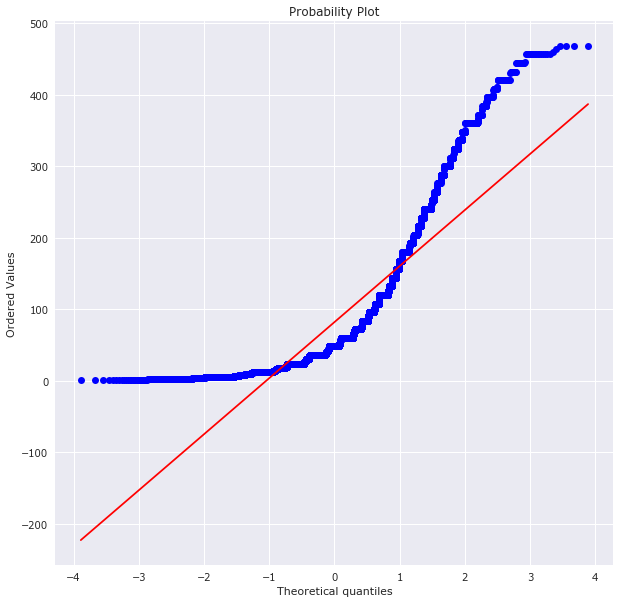

In [22]:
plt.subplots(figsize=(10, 10))

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(data['WORK_TIME'].dropna().sort_values()[:13800], dist="norm", plot=plt)
plt.show()

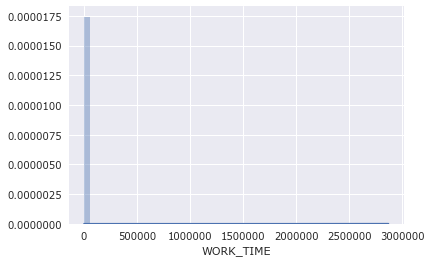

In [23]:
sns.distplot(data['WORK_TIME'].dropna().sort_values().dropna())

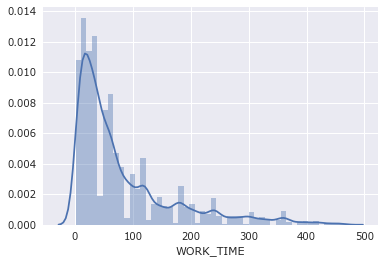

In [24]:
sns.distplot(data['WORK_TIME'].dropna().sort_values()[:13800].dropna())

In [25]:
max(data['WORK_TIME'].dropna().sort_values()[:13800])

468.0

In [26]:
data['WORK_TIME'].dropna().sort_values()[:13800].mean(), data['WORK_TIME'].dropna().sort_values()[:13800].median()

(82.04579710144928, 48.0)

In [27]:
data.at[data['WORK_TIME'] > 468, 'WORK_TIME'] = np.NaN
len(data['WORK_TIME'].dropna())
# стало не слишком больше пропущенных значений

13802

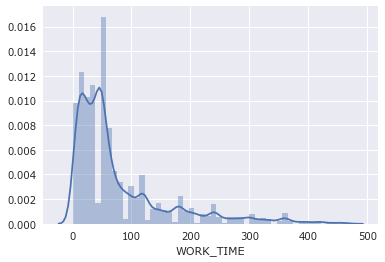

In [28]:
sns.distplot(data['WORK_TIME'].fillna(data['WORK_TIME'].dropna().median()))

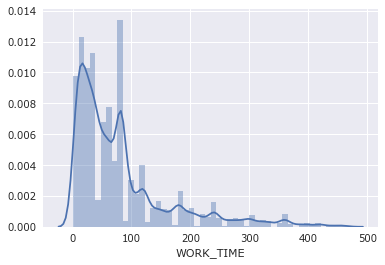

In [29]:
sns.distplot(data['WORK_TIME'].fillna(data['WORK_TIME'].dropna().mean()))

In [30]:
data['WORK_TIME'].fillna(data['WORK_TIME'].dropna().median(), inplace=True)

In [31]:
# есть ли еще пропуски
for i in miss_columns:
    print(data.isnull()[i].value_counts())
    print()
    
miss_columns

False    15223
Name: GEN_INDUSTRY, dtype: int64

False    15223
Name: GEN_TITLE, dtype: int64

False    15223
Name: ORG_TP_STATE, dtype: int64

False    15223
Name: ORG_TP_FCAPITAL, dtype: int64

False    15223
Name: JOB_DIR, dtype: int64

False    15223
Name: TP_PROVINCE, dtype: int64

False    15223
Name: REGION_NM, dtype: int64

False    15223
Name: WORK_TIME, dtype: int64



Index(['GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL',
       'JOB_DIR', 'TP_PROVINCE', 'REGION_NM', 'WORK_TIME'],
      dtype='object')

In [32]:
for i in ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 
          'EDUCATION', 'MARITAL_STATUS', 'GEN_INDUSTRY', 'GEN_TITLE',
          'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR', 'REG_ADDRESS_PROVINCE',
          'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE', 'REGION_NM',
          'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL', 
          'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
          'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
          'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL']:
    
    if i in data.columns:
        data[i]=data[i].astype('str')
        
for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
    if i in data.columns:
        data[i] = data[i].str.replace(',', '.').astype('float')
        
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 50 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDR

In [33]:
for i in categorical_columns:
    print(i)
    print(data[i].value_counts())
    print()

TARGET
0    13411
1     1812
Name: TARGET, dtype: int64

SOCSTATUS_WORK_FL
1    13847
0     1376
Name: SOCSTATUS_WORK_FL, dtype: int64

SOCSTATUS_PENS_FL
0    13176
1     2047
Name: SOCSTATUS_PENS_FL, dtype: int64

GENDER
1    9964
0    5259
Name: GENDER, dtype: int64

EDUCATION
Среднее специальное               6518
Среднее                           4679
Высшее                            3133
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образования      20
Ученая степень                       1
Name: EDUCATION, dtype: int64

MARITAL_STATUS
Состою в браке        9416
Не состоял в браке    3622
Разведен(а)           1245
Вдовец/Вдова           588
Гражданский брак       352
Name: MARITAL_STATUS, dtype: int64

GEN_INDUSTRY
Торговля                                     2385
Другие сферы                                 1709
Пропуски                                     1367
Металлургия/Промышленность/Машиностроение    1356
Государственная с

In [34]:
data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'

data['EDUCATION'].value_counts()

Среднее специальное    6518
Среднее                4679
Высшее                 3154
Неоконченное высшее     532
Неполное среднее        340
Name: EDUCATION, dtype: int64

In [35]:
data['GEN_INDUSTRY'].value_counts()

Торговля                                     2385
Другие сферы                                 1709
Пропуски                                     1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [36]:
small_categories_aggregation('GEN_INDUSTRY', 100)

In [37]:
data['GEN_TITLE'].value_counts()

Специалист                        7010
Рабочий                           3075
Пропуски                          1367
Служащий                           904
Руководитель среднего звена        697
Работник сферы услуг               563
Высококвалифиц. специалист         549
Руководитель высшего звена         427
Индивидуальный предприниматель     217
Другое                             177
Руководитель низшего звена         136
Военнослужащий по контракту         88
Партнер                             13
Name: GEN_TITLE, dtype: int64

In [38]:
data.at[data['GEN_TITLE'] == 'Партнер', 'GEN_TITLE'] = 'Другое'

In [39]:
data['ORG_TP_STATE'].value_counts()

Частная компания                  6523
Государственная комп./учреж.      6112
Пропуски                          1367
Индивидуальный предприниматель     957
Некоммерческая организация         243
Частная ком. с инос. капиталом      21
Name: ORG_TP_STATE, dtype: int64

In [40]:
data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'

In [41]:
data['JOB_DIR'].value_counts()

Участие в основ. деятельности    11452
Пропуски                          1367
Вспомогательный техперсонал       1025
Бухгалтерия, финансы, планир.      481
Адм-хоз. и трансп. службы          279
Снабжение и сбыт                   217
Служба безопасности                164
Кадровая служба и секретариат      101
Пр-техн. обесп. и телеком.          75
Юридическая служба                  53
Реклама и маркетинг                  9
Name: JOB_DIR, dtype: int64

In [42]:
data.at[data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Реклама и юр. услуги'
data.at[data['JOB_DIR'] == 'Юридическая служба', 'JOB_DIR'] = 'Реклама и юр. услуги'

In [43]:
data['TP_PROVINCE'].value_counts()

Краснодарский край         790
Кемеровская область        668
Алтайский край             436
Приморский край            413
Читинская область          412
Ставропольский край        411
Ростовская область         405
Челябинская область        354
Свердловская область       340
Волгоградская область      339
Кировская область          333
Саратовская область        317
Воронежская область        312
Красноярский край          295
Пропуски                   295
Вологодская область        292
Омская область             286
Татарстан                  272
Хабаровский край           258
Санкт-Петербург            254
Оренбургская область       251
Тульская область           245
Архангельская область      243
Новосибирская область      238
Самарская область          236
Амурская область           224
Курская область            212
Бурятия                    211
Белгородская область       211
Ярославская область        208
                          ... 
Пермская область           162
Чувашия 

In [44]:
# потому что соседи
data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'

In [45]:
data['POSTAL_ADDRESS_PROVINCE'].value_counts()

Кемеровская область            674
Краснодарский край             674
Алтайский край                 456
Читинская область              426
Приморский край                415
Ростовская область             404
Свердловская область           348
Волгоградская область          331
Саратовская область            326
Воронежская область            302
Вологодская область            293
Челябинская область            292
Татарстан                      287
Омская область                 286
Кировская область              266
Архангельская область          255
Хабаровский край               254
Оренбургская область           251
Тульская область               249
Красноярский край              239
Самарская область              239
Башкирия                       221
Новосибирская область          215
Курская область                214
Белгородская область           212
Липецкая область               204
Московская область             203
Иркутская область              202
Тюменская область   

In [46]:
'Красноярский край' in list(data['POSTAL_ADDRESS_PROVINCE'])

True

In [47]:
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'

In [ ]:
# частоты
# data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
# data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())

In [51]:
data['SOLVENCY'] = data['PERSONAL_INCOME']/(data['CREDIT']/data['TERM'])

In [52]:
data.head()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,SOLVENCY
0,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000.0,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000.00,6,8650.0,1,220,18.0,0,0,1,1,1,6,2,1,1580.000000,1580.0,0.0,3.750000
1,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000.0,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650.00,6,4000.0,1,137,97.0,1,0,1,1,1,6,1,1,4020.000000,4020.0,0.0,3.325635
2,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Укрупненная категория,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000.0,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126.00,12,4000.0,1,251,84.0,0,0,1,2,1,11,0,0,0.000000,0.0,0.0,3.260279
3,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000.0,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,8491.82,6,5000.0,0,36,168.0,1,1,1,1,1,6,3,1,1589.923333,1590.0,0.0,17.664058
4,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000.0,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990.00,12,4000.0,1,83,101.0,1,0,1,2,1,16,2,1,1152.150000,2230.0,0.0,6.548431


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 51 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDR

In [54]:
data.describe()

,AGE,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,OWN_AUTO,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,SOLVENCY
count,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,1.522300e+04,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000
mean,40.406096,1.099389,0.645208,13853.836323,0.116337,14667.959345,8.101031,3398.562655,3.039340e+03,78.918479,1.387769,0.751889,7.875977,0.195362,0.130198,239.457144,243.021626,0.019050,9.494507
std,11.601068,0.995411,0.812252,9015.467617,0.320844,12147.873496,4.094090,5158.108934,2.624554e+05,84.906057,0.793566,0.988499,7.955747,0.685022,0.355702,827.700432,836.100116,0.137663,7.268978
min,21.000000,0.000000,0.000000,24.000000,0.000000,2000.000000,3.000000,0.000000,-2.600000e+01,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006824
25%,30.000000,0.000000,0.000000,8000.000000,0.000000,6500.000000,6.000000,1000.000000,4.100000e+01,24.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.932261
50%,39.000000,1.000000,0.000000,12000.000000,0.000000,11550.000000,6.000000,2000.000000,1.080000e+02,48.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.547170
75%,50.000000,2.000000,1.000000,17000.000000,0.000000,19170.000000,10.000000,4000.000000,2.040000e+02,96.000000,2.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.819376
max,67.000000,10.000000,7.000000,250000.000000,2.000000,119700.000000,36.000000,140000.000000,2.810200e+07,468.000000,11.000000,11.000000,114.000000,13.000000,8.000000,28012.200000,28012.200000,2.000000,172.479877


In [59]:
# смотреть тетрадку 1 OTP Bank Contest - Data Processing

## Сохраняем данные для R
Чтобы строить деревья CHAID по предикторам с категориями с малым количеством наблюдений и смотреть за объединением категорий

In [35]:
data.to_csv('data/R_CHAID_data.csv', encoding='utf-8')

# Как предлагает бинить CHAID

In [36]:
data_chaid_preparation = data.copy()

In [37]:
data_chaid_preparation.head()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,1,220,18.0,0,0,1,1,1,6,2,1,1580,1580,0.0
1,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,1,137,97.0,1,0,1,1,1,6,1,1,4020,4020,0.0
2,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,1,251,84.0,0,0,1,2,1,11,0,0,0,0,0.0
3,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,36,168.0,1,1,1,1,1,6,3,1,"1589,923333",1590,0.0
4,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,1,83,101.0,1,0,1,2,1,16,2,1,"1152,15",2230,0.0


In [76]:
cat_to_delete = []

In [77]:
def binning(dic_for_binning, column):
    
    new_col = '{}_BINNED'.format(column)
    
    data[new_col] = 0
    
    for cat in dic_for_binning:
        for age in dic_for_binning[cat]:
            data.at[(data[column] == age), new_col] = cat
            
    cat_to_delete.append(column)
    

In [78]:
age_binned_list = {
    '0': [21, 22, 23, 24, 25, 26, 27, 28, 29, 35, 36, 39, 42, 67],
    '1': [30, 31, 32, 33, 34, 37, 38, 40, 41, 46],
    '2': [43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57],
    '3': [56, 58, 59, 60, 61, 62, 63, 64, 65, 66]
}

binning(age_binned_list, 'AGE')
        
data.head()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,AGE_BINNED,EDUCATION_BINNED
0,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,1,220,18.0,0,0,1,1,1,6,2,1,1580,1580,0.0,2,2
1,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,1,137,97.0,1,0,1,1,1,6,1,1,4020,4020,0.0,1,0
2,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,1,251,84.0,0,0,1,2,1,11,0,0,0,0,0.0,2,2
3,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,36,168.0,1,1,1,1,1,6,3,1,"1589,923333",1590,0.0,0,0
4,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,1,83,101.0,1,0,1,2,1,16,2,1,"1152,15",2230,0.0,1,0


In [79]:
# не разбивается дерево
cat_to_delete.append('CHILD_TOTAL')

In [80]:
cat_to_delete.append('DEPENDANTS')

In [81]:
edu_binned_list = {
    '0': ['Высшее', 'Среднее'],
    '1': ['Два и более высших образования', 'Неоконченное высшее', 'Ученая степень'],
    '2': ['Неполное среднее', 'Среднее специальное']
}

binning(edu_binned_list, 'EDUCATION')
        
data.head()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,AGE_BINNED,EDUCATION_BINNED
0,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,1,220,18.0,0,0,1,1,1,6,2,1,1580,1580,0.0,2,2
1,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,1,137,97.0,1,0,1,1,1,6,1,1,4020,4020,0.0,1,0
2,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,1,251,84.0,0,0,1,2,1,11,0,0,0,0,0.0,2,2
3,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,36,168.0,1,1,1,1,1,6,3,1,"1589,923333",1590,0.0,0,0
4,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,1,83,101.0,1,0,1,2,1,16,2,1,"1152,15",2230,0.0,1,0


In [93]:
marital_status_binned_list = {
    '0': ['Вдовец/Вдова', 'Состою в браке'],
    '1': ['Гражданский брак', 'Разведен(а)'],
    '2': ['Не состоял в браке']
}

binning(marital_status_binned_list, 'MARITAL_STATUS')

data.head()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,AGE_BINNED,EDUCATION_BINNED,MARITAL_STATUS_BINNED
0,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,1,220,18.0,0,0,1,1,1,6,2,1,1580,1580,0.0,2,2,0
1,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,1,137,97.0,1,0,1,1,1,6,1,1,4020,4020,0.0,1,0,0
2,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,1,251,84.0,0,0,1,2,1,11,0,0,0,0,0.0,2,2,0
3,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,36,168.0,1,1,1,1,1,6,3,1,"1589,923333",1590,0.0,0,0,0
4,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,1,83,101.0,1,0,1,2,1,16,2,1,"1152,15",2230,0.0,1,0,0


In [ ]:
data.at[(data['AGE'] >= 65), 'AGE'] = 64
data.at[(data['AGE'] <= 22), 'AGE'] = 22

In [94]:
for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
    if i in data.columns:
        data[i] = data[i].str.replace(',', '.').astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 53 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDR

In [ ]:
data['AGE_CATEGORY'] = 0

data.at[data['AGE'] <= 30, 'AGE_CATEGORY'] = '1'
data.at[(data['AGE'] >= 31) & (data['AGE'] <= 40), 'AGE_CATEGORY'] = '2'
data.at[(data['AGE'] >= 41) & (data['AGE'] <= 50), 'AGE_CATEGORY'] = '3'
data.at[(data['AGE'] >= 51) & (data['AGE'] <= 60), 'AGE_CATEGORY'] = '4'
data.at[(data['AGE'] >= 61) & (data['AGE'] <= 70), 'AGE_CATEGORY'] = '5'

data['AGE_CATEGORY'].value_counts()

In [50]:
DataFrame.from_csv("data/Credit_OTP_new.csv", encoding='cp1251', sep = ';').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14910 entries, 75286343 to 66524602
Data columns (total 51 columns):
TARGET                        14910 non-null int64
AGE                           14910 non-null int64
SOCSTATUS_WORK_FL             14910 non-null int64
SOCSTATUS_PENS_FL             14910 non-null int64
GENDER                        14910 non-null int64
CHILD_TOTAL                   14910 non-null int64
DEPENDANTS                    14910 non-null int64
EDUCATION                     14910 non-null object
MARITAL_STATUS                14910 non-null object
GEN_INDUSTRY                  14910 non-null object
GEN_TITLE                     14910 non-null object
ORG_TP_STATE                  14910 non-null object
ORG_TP_FCAPITAL               14910 non-null object
JOB_DIR                       14910 non-null object
FAMILY_INCOME                 14910 non-null object
PERSONAL_INCOME               14910 non-null object
REG_ADDRESS_PROVINCE          14910 non-null object
FACT